In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd DeepLearning_Financial

/data/home/dsvm_server_admin/notebooks/fastai/tesi/DeepLearning_Financial


In [3]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELoss
import tensorflow as tf
from tensorflow import keras
from skorch.dataset import CVSplit
from skorch import callbacks
import pickle
from sklearn.model_selection import train_test_split
from functools import partial
import skorch
import pywt
from sklearn import preprocessing
import joblib


##INTERNAL
from models import Autoencoder, waveletSmooth, SequenceDouble, SequenceDoubleAtt, SequenceAtt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest
from testing import *
from sa_tools import *
from test_models import *

## Creazione dei dataset

In [4]:
# len(list(tss.split(X))[0])

In [5]:
# tss = TimeSeriesSplit(4)
# tss_split = CVSplit(cv=tss, stratified=False, random_state=None)


# X=datasets['^GSPC']["target"]
# for i, (train, val) in enumerate(tss.split(X), start=1):
#     print("FOLD {}".format(i))
#     train_dates = X.index[train]
#     val_dates = X.index[val]
#     print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
#     print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))
#     print(X.index.min())
#     print(X.index.max())

In [12]:
datasets['^GSPC']["features"].keys()

dict_keys(['open', 'ohlcv', 'ext'])

In [10]:
tss.split(datasets['^GSPC']["features"])

<generator object TimeSeriesSplit.split at 0x7f63c2890888>

In [46]:
indices = ['^GSPC', '^DJI', '^HSI', '^N225', 'ASHR','^NSEI']
feature_sets = ['open', 'ohlcv', 'ext']
start_date="2000-01-01"
end_date="2018-12-31"

datasets= load('^GSCP')
tss = TimeSeriesSplit(4)


for model_name, feature_set in [('lstm_moro', 'open'), ('lstm_sa', 'ext_sa'), ('lstm_sa_att', 'ext_sa'), ('lstm_att', 'ohlcv')]:
    for index_name in ['^GSPC']:
        split_periods = ['2000-09-19_2004-05-18', '2000-09-19_2008-01-12']
        scores = pd.DataFrame(index=split_periods)
        scores["mape"] = pd.Series([], dtype=np.float32)
        scores["mspe"] = pd.Series([], dtype=np.float32)
        scores["acc"] = pd.Series([], dtype=np.float32)
        scores["r2"] = pd.Series([], dtype=np.float32)
        scores["roi"] = pd.Series([], dtype=np.float32)
        scores["valid_loss"] = pd.Series([], dtype=np.float32)
        scores["epochs"] = pd.Series([], dtype=np.float32)
        for split_period in split_periods:
            model_full_name = "{}_{}_{}".format(model_name, index_name, split_period)
            model = load(model_full_name)

            split = model.train_split
            train_dates, valid_dates = list(tss.split(datasets[index_name]["target"]))[1]
            
            sa=None
            ld=True
            fset= feature_set
            if(feature_set is 'ext_sa'):
                fset='ext'
                sa = "sa_{}_{}".format(index_name, split_period)
            x, y, x_train, x_val, x_scaler, y_train, y_val, y_scaler = get_dataset_train(datasets=datasets, feature_set=fset, train_dates=train_dates, val_dates=valid_dates, index=index_name, sa=sa, ld=ld)

            n_days=5
            x_batch = days_group(x, n_days=n_days)
            y_batch = y[n_days:]
            serie = x_batch
            train_dates_s = train_dates[n_days:].copy()
            val_dates_s = valid_dates.copy()

            splitted = np.split(serie, [len(train_dates_s)])
            l1, l2 = len(splitted[0]), len(splitted[1])
            train_s = PredefinedSplit(np.concatenate((np.ones(l1)*-1,np.ones(l2))))
            train_split =  CVSplit(cv=train_s, stratified=False, random_state=None)  
            train_dates_t, val_dates_t = list(train_s.split(serie))[0]

            train_dates_s, valid_dates_s =datasets[index_name]["target"].index[train_dates_t], datasets[index_name]["target"].index[val_dates_t]
            opn_test = datasets[index_name]["original"]["Open"].loc[valid_dates_s]
            close_test = datasets[index_name]["target"].loc[valid_dates_s]

            x_test_batch = x_batch[val_dates_t]


            pred = model.predict(x_test_batch).squeeze()
            pred_unsc = pd.Series(y_scaler.inverse_transform(pred), index=close_test.index)
            
            roi_test = partial(roi,opn=opn_test)
            mape = (abs(close_test - pred_unsc)/close_test).mean()
            mspe = (((close_test - pred_unsc)/close_test)**2).mean()
            acc = 1 - mape
            roi_score = roi_test(close_test, pred_unsc)
            r2_score = sklearn.metrics.r2_score(close_test, pred_unsc)

            
            scores["mape"][split_period] = mape
            scores["mspe"][split_period] = mspe
            scores["acc"][split_period] = acc
            scores["r2"][split_period] = r2_score
            scores["roi"][split_period] = roi_score
            scores["valid_loss"][split_period] = model.history[-1]["valid_loss"]
            scores["epochs"][split_period] = len(model.history)
            
            t_dates, val_dates = list(model.train_split.cv.split(datasets[index_name]["features"]))[0]
            t_dates_s, val_dates_s =datasets[index_name]["target"].index[t_dates], datasets[index_name]["target"].index[val_dates]
#             print("\n----{}----".format(model_full_name))
#             print("Training set da {} a {}".format(t_dates_s.min(), t_dates_s.max()))
#             print("Valid set da {} a {}".format(val_dates_s.min(), val_dates_s.max()))
#             print("Test set da {} a {}".format(valid_dates_s.min(), valid_dates_s.max()))
#             print("mape: %.4f\nmspe: %.4f\nacc: %.4f\nR2: %.4f\nroi: %.4f"% (mape, mspe, acc, r2_score, roi_score))
#             print("valid_loss: %.4f" % (model.history[-1]["valid_loss"]))
#             print("epochs: {}".format(len(model.history)))
        print("\n----{}----".format(model_name))
        print(scores)
        print(scores.describe())


----lstm_moro----
                           mape      mspe       acc        r2       roi  \
2000-09-19_2004-05-18  0.018890  0.001367  0.981110  0.968690  6.861156   
2000-09-19_2008-01-12  0.015038  0.000507  0.984962  0.983221  7.443764   

                       valid_loss  epochs  
2000-09-19_2004-05-18    0.012104   789.0  
2000-09-19_2008-01-12    0.019203   859.0  
           mape      mspe       acc        r2       roi  valid_loss  \
count  2.000000  2.000000  2.000000  2.000000  2.000000    2.000000   
mean   0.016964  0.000937  0.983036  0.975955  7.152460    0.015654   
std    0.002724  0.000608  0.002724  0.010275  0.411966    0.005020   
min    0.015038  0.000507  0.981110  0.968690  6.861156    0.012104   
25%    0.016001  0.000722  0.982073  0.972323  7.006808    0.013879   
50%    0.016964  0.000937  0.983036  0.975956  7.152460    0.015654   
75%    0.017927  0.001152  0.983999  0.979588  7.298112    0.017429   
max    0.018890  0.001367  0.984962  0.983221  7.443764

In [ ]:
x_test_batch.shape

In [ ]:
pd.Serie(x_test_batch['r2'])

In [ ]:
close_test.plot()
pred_unsc.plot()

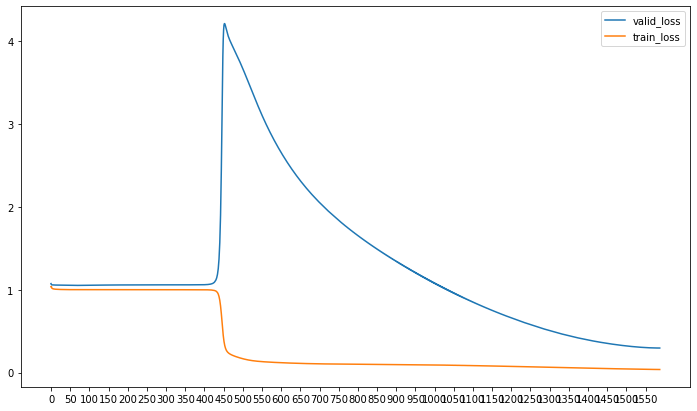

In [47]:
lstm = model
valid_losses = lstm.history[:, 'valid_loss']
train_losses = lstm.history[:, 'train_loss']
plt.figure(figsize=(12,7))
plt.plot(valid_losses, label='valid_loss')
plt.plot(train_losses, label='train_loss')
plt.xticks(np.arange(len(valid_losses)+1, step=50))
plt.legend()